# Copyright 2022 Cognite AS
# Deploying a Cognite Function via the Cognite Data Fusion UI

In this part of the hands-on exercise, we will show you how to use the Fusion UI to create the same function that you created in the previous part with the Python SDK. Additionally, we will show you how to create a schedule for your function and how to modify the handler to write to time series.


## Creating a Cognite Function via the UI

As you may remember from Part 2, we created a Cognite Function using the Python SDK by referencing the relevant folder that has all of our code. This included the following files:

* handler.py
* tools.py
* requirements.txt

Take all of these 3 files (they are present in `hx-thermal-resistance`), and zip them into a single file. Afterwards navigate to the following link to get to the UI page for Cognite Functions: https://cognite-learn.fusion.cognite.com/ds-cognitefunctions/functions?cluster=westeurope-1.cognitedata.com&env=westeurope-1

Click on "Upload Function" and you will be taken to a window similar to the screenshot below.

<img src="../images/cognite-functions-via-UI.jpg">

## List and call functions via SDK

Let's see the Cognite Function that we just created using the SDK tools. 

In [1]:
from cognite.client import CogniteClient, ClientConfig
from cognite.client.credentials import Token
from msal import PublicClientApplication


# Enter your name here
YOUR_NAME = "Andris-Piebalgs"

# Contact Project Administrator to get these
TENANT_ID="48d5043c-cf70-4c49-881c-c638f5796997"
CLIENT_ID="1c224c70-1df2-4f05-964a-753a6731748a"
CDF_CLUSTER="westeurope-1"
COGNITE_PROJECT="ds-cognitefunctions"

SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]
TOKEN_URL = f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/v2.0/token"
AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000

def authenticate_azure():

    app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)

    # interactive login - make sure you have http://localhost:port in Redirect URI in App Registration as type "Mobile and desktop applications"
    creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)
    return creds

creds = authenticate_azure()


cnf = ClientConfig(client_name="my-special-client", project=COGNITE_PROJECT, credentials=Token(creds["access_token"]), base_url=f"https://{CDF_CLUSTER}.cognitedata.com")
client = CogniteClient(cnf)

Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


Now take your zipped file and upload it to the Function File by dragging and dropping. Give your function a name and put yourself down as the Owner. Once you have created your function you can test if it has run properly by calling it. 

In [1]:
# Find the id of your function using the list operation below
client.functions.list()

NameError: name 'client' is not defined

In [6]:
# Call function as required
function_id = 5033870407239562 # replace this with the id of the function that you created
call = client.functions.call(function_id)
call

,value
id,8620207370279392
start_time,1660318395737
end_time,1660318401308
status,Completed
function_id,5033870407239562


In [7]:
# If successfully completed, you can return the response
call.get_response()

'{"TR":{"1533081600000":0.000000392,"1533081660000":0.0000003882,"1533081720000":0.0000003949,"1533081780000":0.0000004024,"1533081840000":0.0000003931}}'

## Creating a Schedule for your Cognite Function

When creating function in CDF UI, we can also create the schedule with Cron syntax (https://crontab.guru/). 

For example,
- for hourly schedule, enter this cron expression `0 * * * *`
- for daily `0 0 * * *` 
- for every minute `* * * * *` 

On the Fusion UI for Functions, you can navigate to the "Schedules" tab under your created function as shown in the screenshot below. Click "Create Schedule"

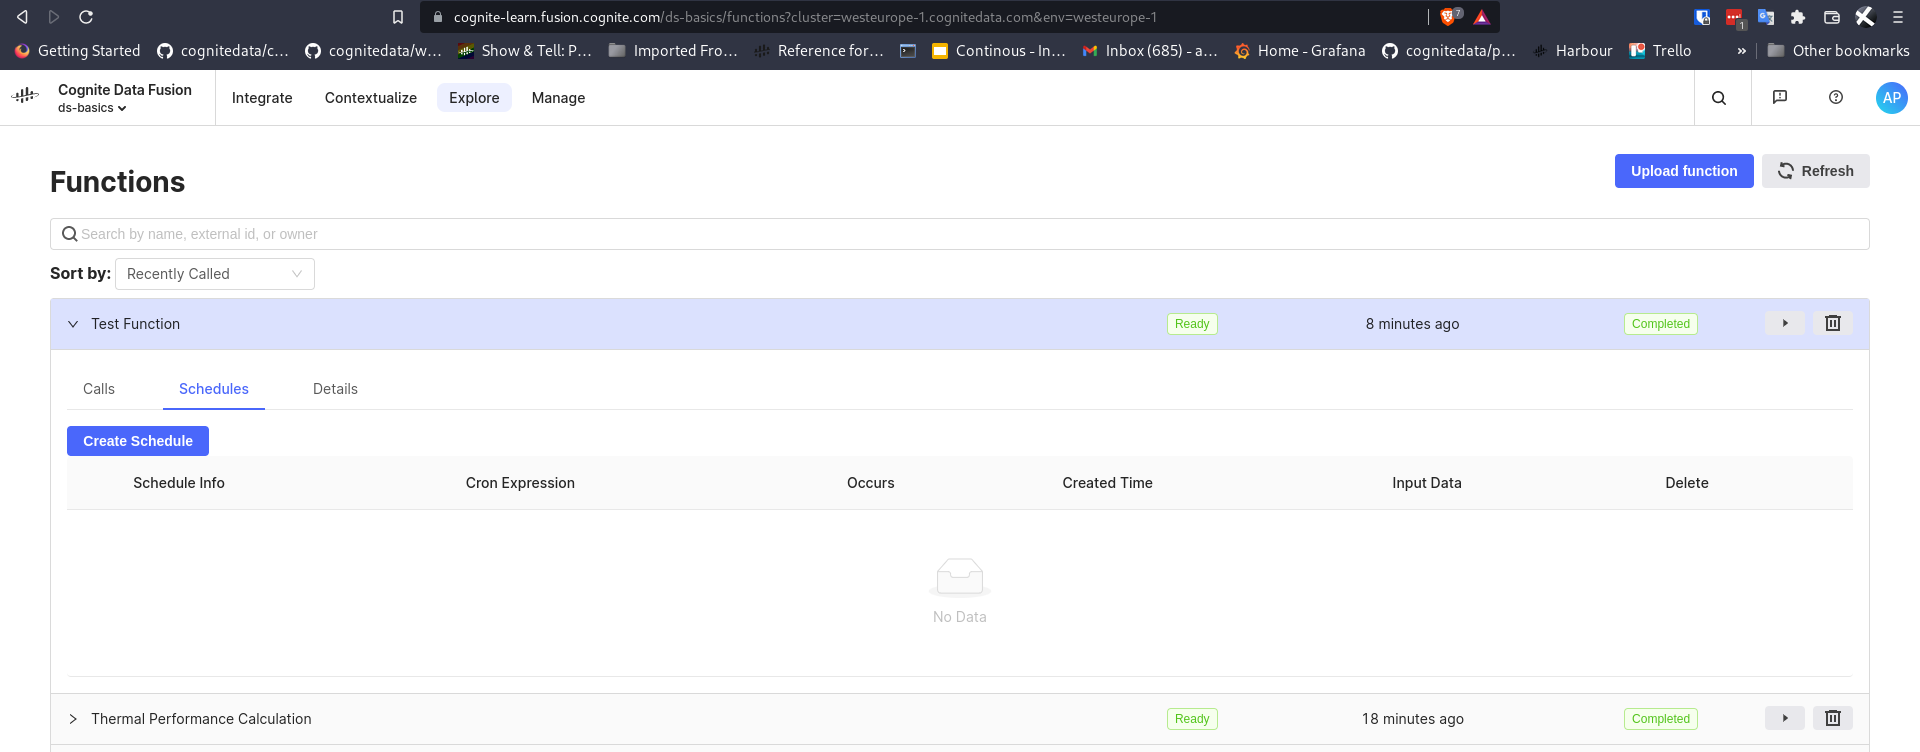

You will be asked to give a name for your schedule and a schedule. Let's execute the function every 5 minutes with the cron syntax `*/5 * * * *`. 

Note that you will have to specify the Client ID and the Client Secret.


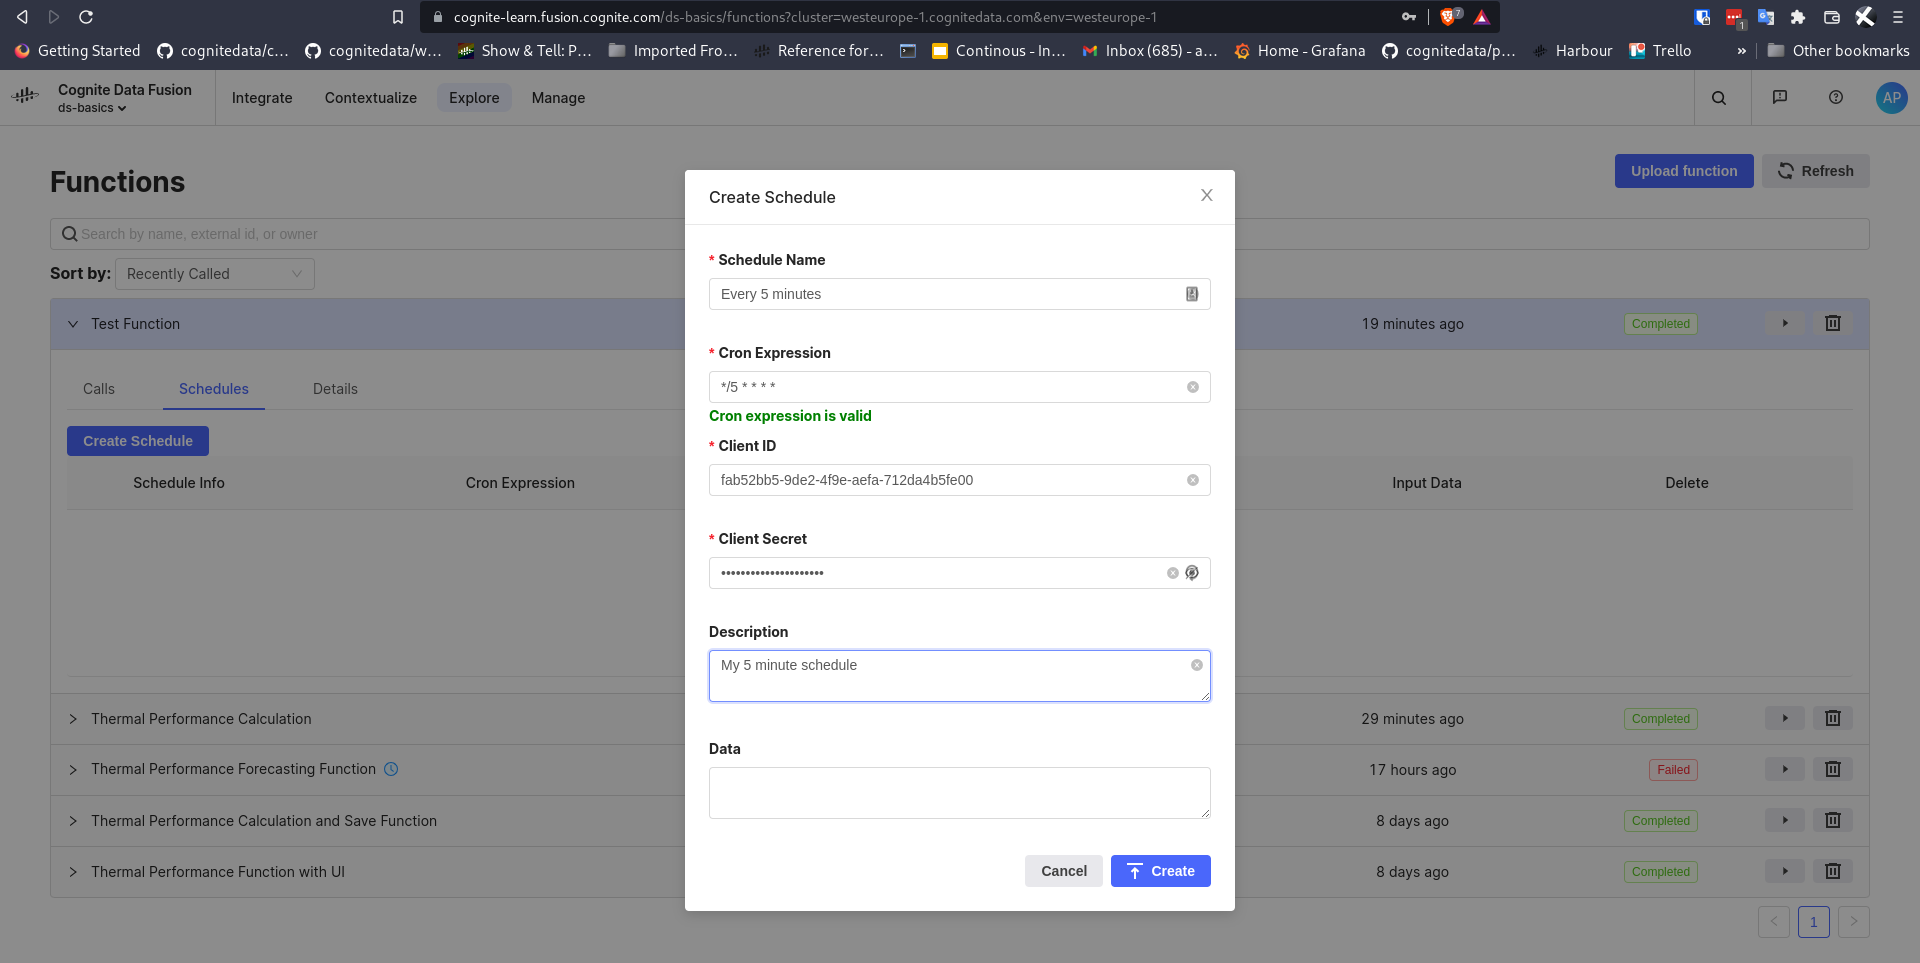

If successful, then the function will execute every 5 minutes. You can see all the calls that have happened with the commands below:

In [ ]:
function = client.functions.retrieve(function_id)
calls = function.list_calls()
calls

## Modify Cognite Function to write back to CDF

In the cognite functions, we can also persist the result into a time series or other resource type suitable for the result.
Let's add some extra lines of code to save the calculated values in a time series.

In [ ]:
from cognite.client.data_classes import TimeSeries
from math import log
import datetime
from datetime import timedelta

def thermal_resistance(x):
    '''Function to calculate Thermal Resistance'''
    # Some constants like Correction factor, Area and Cp values
    F = 0.8
    A = 1.0
    Cp_hot = 2.4
    Cp_cold	= 4.18
    # Calculate the cross temperature differences
    x['dT1'] = x['T_hot_IN'] - x['T_cold_OUT']
    x['dT2'] = x['T_hot_OUT'] - x['T_cold_IN']
    # Calculate the numerator and denominator for the thermal resistance calculation
    temp1 = A*F*(x['dT1']-x['dT2'])/log(x['dT1']/x['dT2'])
    temp2 = x['Flow_hot']*Cp_hot*(x['T_hot_IN']-x['T_hot_OUT'])
    tr = temp1/temp2
    return tr

def create_and_save_time_series_data(client,data, your_name):
    '''Function to create the time series and save the data'''
    
    ts_external_id = f"hx_thermal_resistance_{your_name}"
    cdf_ts = client.time_series.retrieve(external_id=ts_external_id)
    
    if cdf_ts is None:
        ts = TimeSeries(external_id=ts_external_id,name="Thermal Resistance", unit = 'm2K/W')
        client.time_series.create(ts)
        print("Created time series")
    else:
        print("Existing Time Series")
    
    dps = []
    for index, r in data.iterrows():
        dps= dps+[{"timestamp": r.name, "value": r['TR']}]
    
    print(dps)
    client.datapoints.insert(datapoints = dps,external_id = ts_external_id)
    


def handle(client, data=None, secrets=None, function_call_info=None):
    """Handler Function to be Run/Deployed
    Args:
        client : Cognite Client (not needed, it's availble to it, when deployed)
        data : data needed by function
        secrets : Any secrets it needs
        function_call_info : any other information about function

    Returns:
        response : response or result from the function 
    """
    ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']
    column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]
    your_name = data['your_name'] # to be used for creating a unique time series external id
    # Retrieve the data
    start_date = datetime.datetime(2018, 8, 1)
    end_date = start_date + timedelta(days=30)
    df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                        aggregates=['average'],
                                                        granularity='6h',
                                                        start=start_date,
                                                        end=end_date,
                                                        include_aggregate_name=False
                                                        )
    df.fillna(method="ffill", inplace=True)
    df.columns = column_names
    # Calculate the Thermal resistance
    df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)
    # Save the Result as time series
    create_and_save_time_series_data(client,df[['TR']], your_name)
    # Return the result as json
    result = df[['TR']].to_json()
    return result

Update the handler.py file with the above code and deploy the function again to see the persisted result in a time series. We can create a new folder for this function & put the updated handler.py file and requirements.txt in it.

In [11]:
client.functions.list()

,id,name,owner,status,file_id,function_path,created_time,cpu,memory,runtime,metadata
0,5033870407239562,Thermal resistance via UI,Andris Piebalgs,Ready,5641143137429455,handler.py,1660317936170,0.25,1.0,py38,{}
1,5818277302571204,Thermal resistance save calc,NaN,Ready,7073212198927083,handler.py,1660319286745,0.25,1.0,py38,{}


In [ ]:
# You can use the code below if you want to deploy your Cognite Function via the SDK

'''
#folder_dir = <YOUR_CUSTOM_FOLDER> # location of your code and folder directory
folder_dir ='../solutions/hx-thermal-resistance-save-calc/'
function_xid = f"thermal-perf-save-calc-{YOUR_NAME}"


function = client.functions.create(
    name="Thermal Performance Calculation and Save Function",
    external_id=function_xid,
    folder=folder_dir,
    description="Function to Calculate & Save Thermal Performance of Discharge Coolers",
    owner=YOUR_NAME
    )
'''

from function_tools import status_check
status_check(function)

In [12]:
function = client.functions.retrieve(5818277302571204)

In [13]:
# Note that here we use the data keyword to pass in arguments required for our function
call = function.call(data={'your_name':YOUR_NAME})
call

,value
id,5671878042782931
start_time,1660320384343
end_time,1660320391194
status,Completed
function_id,5818277302571204


<AxesSubplot:>

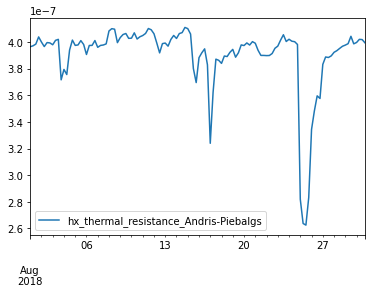

In [14]:
import datetime
# Check if time series has been written back to and plot
df=client.datapoints.retrieve(external_id = f"hx_thermal_resistance_{YOUR_NAME}", start=datetime.datetime(2018, 8, 1), end=datetime.datetime(2018, 9, 1)).to_pandas()
df.plot()

## Cleanup 

Let's delete the functions that we created and the time series

In [15]:
client.functions.list()

,id,name,owner,status,file_id,function_path,created_time,cpu,memory,runtime,metadata
0,5033870407239562,Thermal resistance via UI,Andris Piebalgs,Ready,5641143137429455,handler.py,1660317936170,0.25,1.0,py38,{}
1,5818277302571204,Thermal resistance save calc,NaN,Ready,7073212198927083,handler.py,1660319286745,0.25,1.0,py38,{}


In [16]:
# Make sure to delete your function at the end
client.functions.delete([5033870407239562, 5818277302571204])

In [17]:
# Let's delete the time series that we created
client.time_series.delete(external_id=f"hx_thermal_resistance_{YOUR_NAME}")